In [1]:
import matplotlib.pyplot as plt

# Simple utility function to display image comparisons
def side_by_side(left, right):
    plt.figure(figsize=(15, 10))

    plt.subplot(121)
    plt.imshow(left, cmap='gray')

    plt.subplot(122)
    plt.imshow(right, cmap='gray')
    
    plt.show()

## Camera Calibration

In [2]:
from glob import glob
import numpy as np
import cv2

object_points = []
image_points = []
for pathname in glob('camera_cal/*.jpg'):
    image = cv2.imread(pathname, cv2.IMREAD_GRAYSCALE)
    ret, corners = cv2.findChessboardCorners(image, (9, 6))
    
    # Check if all corners have been detected
    if ret == 0: continue
    
    object_points.append([
        [0., 0., 0.], [8., 0., 0.],
        [0., 5., 0.], [8., 5., 0.],
    ])
    
    image_points.append([
        corners[0][0], corners[8][0], 
        corners[45][0], corners[53][0]
    ])

object_points = np.array(object_points, dtype=np.float32)
image_points = np.array(image_points, dtype=np.float32)
    
ret, cmtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image.shape[::-1], None, None)

## Lane detection pipeline

### Distortion correction

In this first step, we correct for distortions introduced by the camera lenses. This is possible thanks to camera calibration we did earlier.

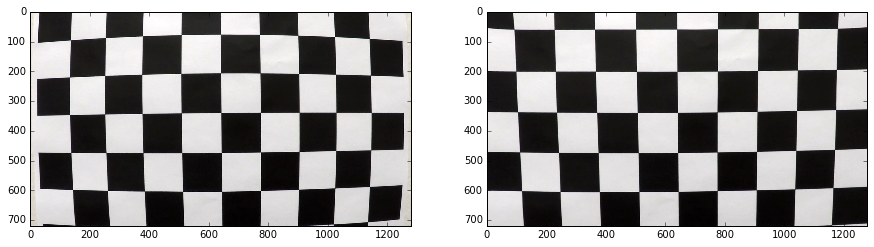

In [3]:
image = cv2.imread('camera_cal/calibration1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(image, cmtx, dist)

side_by_side(image, undistorted)

### Image binarization (thresholding)

Binarize the image to extract pixels belonging to lane lines.

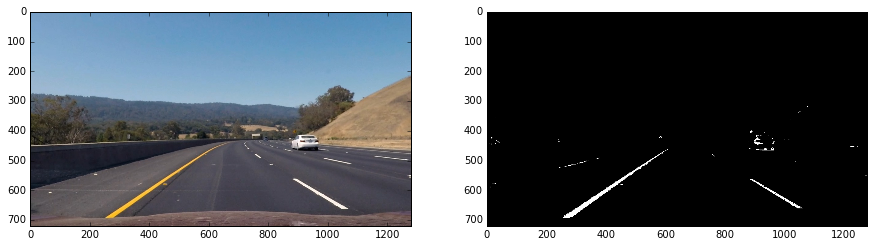

In [4]:
def binarize(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    stn = hls[:, :, 2]

    stn_mask = np.zeros_like(stn)
    stn_mask[stn >= 128] = 1

    return stn_mask

image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, cmtx, dist)

side_by_side(undistorted, binarize(undistorted))

## Perspective transform

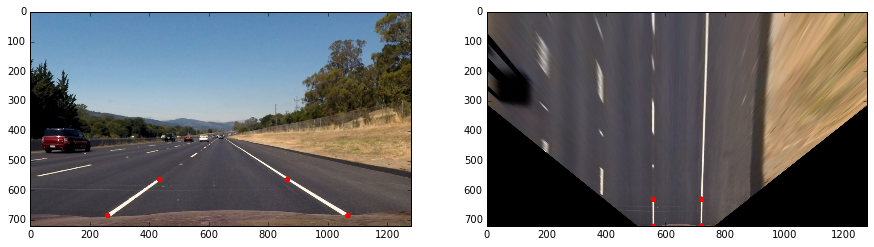

In [5]:
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, cmtx, dist)

src = np.float32([
    [260, 685],
    [434, 563],
    [863, 563],
    [1065, 685],
])

dst = np.float32([
    [558, 720],
    [558, 630],
    [720, 630],
    [720, 720]
])

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(undistorted, M, undistorted.shape[1::-1])

for point in src:
    cv2.circle(undistorted, tuple(point), 9, (255, 0, 0), -1)

for point in dst:
    cv2.circle(warped, tuple(point), 9, (255, 0, 0), -1)

side_by_side(undistorted, warped)